# Grid Serarch with PyTorch #

This network creates a neural network for each monk. The best combination of hyperparameters is selected performing a grid search over a given dictionary (each monk has its own dicitonary). Below there is a brief account about the implementation of each monk's neural netowork; for each monk dataset we built a neural network with only one hidden layer

## Monk1 ##

hyperparameters considered for the grid search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layer

Model created using early stopping.\
Model selection performed using a cross validation.\
Model assessment performed using hold out

## Monk 2 ##

hyperparameters considered for the grid search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layer

Model created using early stopping.\
Model selection performed using a cross validation.\
Model assessment performed using hold out

## Monk 3 ##

hyperparameters considered for the grid search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layer
4. The lambda coefficient for ridge regularisation

Model created using early stopping.\
Model selection performed using a cross validation.\
Model assessment performed using hold out


In [43]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math
import sys
import os
import itertools
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

from multiprocessing import Process
from multiprocessing import Queue

create reproducible results

In [2]:
seed = 2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

function to load the datasets for the monk

In [46]:
def load_monk_dataset(local_path):

    # Load the dataset
    data = np.loadtxt(local_path, delimiter=" ", dtype='str')

    # delete useless cols
    data = data[:, 1:]
    data = data[:, :7]
    data = data.astype('float32')

    # shuffle the input
    data = shuffle(data)

    # divide into input and target
    x_data = (data[:, 1:7])
    y_data = (data[:, [0]])

    # perform one-hot encoding
    one_hot_encoder_tr = OneHotEncoder(sparse=False)
    one_hot_encoder_tr.fit(x_data)
    x_data = one_hot_encoder_tr.transform(x_data)

    # recreate the design set
    data = np.concatenate((y_data, x_data), axis = 1)
    
    return data

the class MonkDataset has been used to create a valid dataset for the neural network

In [44]:
#Loading the monk dataset
class MonkDataset(Dataset):
    
    def __init__(self, data):
        # division between training and validation
        data_x = (data[:, 1:19])
        data_y = (data[:, [0]])
                
        # conversion from numpy array to tensor
        self.x = torch.from_numpy(data_x)
        self.y = torch.from_numpy(data_y)
        
        # convert to float32
        self.x = self.x.to(torch.float32)
        self.y = self.y.to(torch.float32)
        
        # save the number of patterns in the training/validation set
        self.n_samples = data_x.shape[0]
        
    # return a specific tensor
    def __getitem__ (self, index):
        return self.x[index], self.y[index]
    
    # return the total number of patterns
    def __len__(self):
        return self.n_samples

The class MonkNeuralNet outlines the structure of the neural network

In [5]:
class MonkNeuralNet(nn.Module):
    # define the neural network's structure
    def __init__(self, input_size, hidden_size, num_output):
        super(MonkNeuralNet, self).__init__()
        self.hl = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.ol = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    # Forward pass of the neural network
    def forward(self, x):
        out = self.hl(x)
        out = self.relu(out)
        out = self.ol(out)
        out = self.sigmoid(out)
        return out

The class EarlyStopper has been used to implement early stopping

In [6]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        # lowest error on the validation set ever reached
        self.min_validation_loss = np.inf
        
    # call this method at the end of each epoch, to check wheter the loss on the validation set decreased or not
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.counter = 0
            self.min_validation_loss = validation_loss
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

The function below train a model given a training set, a validation set, and a proper dictionary of hyper parameters. It returns the final score on the validation set

In [7]:
def trial_model_construction(
    dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, 
    total_samples_tr, total_samples_vl, num_epochs, verbose
):
      
    # list of hyperparameters
    hidden_size = None
    learning_rate = None
    momentum = None
    ridge_lambda = None
    
    # retrieve the combination of hyperparameters from the dictionary
    try:
        hidden_size = hyper_parameters['hidden_size']
    except:
        print("hidden_size not passed")
        hidden_size = 1
    try:
        learning_rate = hyper_parameters['learning_rate']
    except:
        print("learning rate not passed")
        learning_rate = 0.1
    try:
        momentum = hyper_parameters['momentum']
    except:
        print("momentum not passed")
        momentum = 0.3
    try:
        ridge_lambda = hyper_parameters['ridge_lambda']
    except:
        print("ridge lambda not passed")
        ridge_lambda = 0.0
    
    
    # initialize the model and the optimizer
    model = MonkNeuralNet(input_size, hidden_size, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=ridge_lambda)
    criterion = nn.MSELoss()

    # n_iter = math.ceil(total_samples_tr/batch_size)
    
    # save the final accuracy on the validation set
    val_accuracy = None

    # execute early stopping (patience = 8)
    early_stopper = EarlyStopper(patience=8)
    for epoch in range(num_epochs):

        #training loop
        model.train()
        correct = 0
        batch_loss = 0
        for i, (inputs, labels) in enumerate(dataloader_tr):

            # forward pass
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the label predicted by the model and the accuracy
            pred_lab_tr = (outputs>0.5).float()
            correct += (pred_lab_tr == labels).float().sum()        

            # compute the loss on the training set
            batch_loss += loss.item() * inputs.size(0)


        #validation loop
        model.eval()
        val_correct = 0
        val_batch_loss = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader_vl):

                # evaluate the performance of the model on the validation set
                inputs = inputs.to(torch.float32)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # compute the label predicted by the model
                pred_lab_vl = (outputs>0.5).float()
                val_correct += (pred_lab_vl == labels).float().sum()
                
                # compute the loss on the training set
                val_batch_loss += loss.item() * inputs.size(0)


        # compute the accuracy on both training set and validation set
        accuracy = correct / total_samples_tr
        val_accuracy = val_correct / total_samples_vl
        
        # compute the average loss on both training set and validation set
        epoch_loss =  batch_loss / total_samples_tr # len(dataloader_tr.sampler)
        val_epoch_loss = batch_loss / total_samples_vl # len(dataloader_vl.sampler)

        # look if condition for early stopping is satisfied
        es = early_stopper.early_stop(val_epoch_loss)
        if es:
            if verbose == 2:
                print("condition for early stopping is satisfied")
            break

        if verbose == 2:
            print(
                "epoch n. ", epoch, " accuracy ", accuracy.item(), " val_accuracy", val_accuracy.item(),
                "loss", epoch_loss, "val_loss", val_epoch_loss
            )
        
        
    #return the final accuracy on the validation set
    return val_accuracy.item()

The function execute_different_trials return the average score obtained by building different models with the same training set, validation set and hyperparameters

In [8]:
def average(lst):
    return sum(lst) / len(lst)

def execute_different_trials(
    dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, n_trials, 
    total_samples_tr, total_samples_vl, num_epochs, verbose
):
    
    score_list = []
    for i in range(n_trials):
        
        score = trial_model_construction(
            dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters,
            total_samples_tr, total_samples_vl, num_epochs, verbose
        )
        
        score_list.append(score)
    
    return average(score_list)

the function cross_validation_trials implement the cross validation to find the best combination of hyperparameters

In [9]:
def cross_validation_trials(
    training_set, input_size, output_size, hyper_parameters, n_trials,
    num_epochs, n_kfolds, batch_size, verbose
):
    score_list = []
    # creation of the kfolds for the cross validation
    cross_partitions = model_selection.KFold(n_kfolds)
    for train_indices, valid_indices  in cross_partitions.split(training_set):
        # division into training set and validation
        cv_train, cv_val = training_set[train_indices], training_set[valid_indices]
        
        # compute number of patterns in both training set and validation set
        total_samples_tr = len(cv_train)
        total_samples_vl = len(cv_val)
        
        # create a pytorch dataloader for the training set
        dataset_tr = MonkDataset(cv_train)
        dataloader_tr = DataLoader(dataset=dataset_tr, batch_size=batch_size, shuffle=True)

        # create a pytorch dataloader for the validation set
        dataset_vl = MonkDataset(cv_val)
        dataloader_vl = DataLoader(dataset=dataset_vl, batch_size=len(cv_val))
        
        # retrieve the final score
        score = execute_different_trials(
            dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, n_trials, 
            total_samples_tr, total_samples_vl, num_epochs, verbose
        )
        
        score_list.append(score)
    
    final_score = average(score_list)
    
    if verbose == 1 or verbose == 2:
        output = "score: "
        output += str(final_score)
        output += ", hyperparameters: "
        for i in hyper_parameters:
            output += "("
            output += i
            output += " = "
            output += str(hyper_parameters[i])
            output += ") "
        print(output)
        
    return final_score

Define the cartesian product among the hyperparameters

In [10]:
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

The function below define the grid search for the model selection phase

In [11]:
def grid_search_process(
    training_set, input_size, output_size, hyper_parameters, n_trials, num_epochs, n_kfolds,
    batch_size, verbose, total_process, num_pr, shared_queue
):
    max_score = sys.float_info.min
    best_comb = None
    
    # try all the possible combinations
    for i in range(num_pr, len(hyper_parameters), total_process):
        score = cross_validation_trials(
            training_set, input_size, output_size, hyper_parameters[i], n_trials,
            num_epochs, n_kfolds, batch_size, verbose
        )
    
        if score > max_score:
            max_score = score
            best_comb = hyper_parameters[i]
    
    shared_queue.put([max_score, best_comb])
        

below there is the function which implement the grid search over a combination of hyperparameters

In [12]:
# perform a grid search over a dictionary of hyperparameters
def grid_search(
    training_set, input_size, output_size, hyper_parameters, n_trials, num_epochs, n_kfolds,
    batch_size=16, verbose=0, total_process=1
):
    # compute cartesian product among all the hyperparameterss
    cart_prod = makeGrid(hyper_parameters)
    
    # list of threads
    processes = [None]*total_process

    # queue containing the best pairs (score, hyperparameters) for each process
    shared_queue = Queue()
    
    
    for i in range(total_process):
        processes[i] = Process(
            target=grid_search_process,
            args=(training_set, input_size, output_size, cart_prod, n_trials, num_epochs, n_kfolds,
                  batch_size, verbose, total_process, i, shared_queue)
        )
    
    # wait the execution of the threads
    for pr in processes:
        pr.start()
    
    # join and return the final value of each thread
    for i in range(len(processes)):
        processes[i].join()
        
    
    # find the maximum global score (among all the threads)
    max_global_score = sys.float_info.min
    best_global_hp_comb = None
    while not shared_queue.empty():
        pair = shared_queue.get()
        if max_global_score < pair[0]:
            max_global_score = pair[0]
            best_global_hp_comb = pair[1]
            
            
    print(
        'best score', max_global_score,
        'best combination of hyper parameters', best_global_hp_comb
    )
    
    return max_global_score, best_global_hp_comb

function to divide the design set into training set and validation

In [13]:
def validation_split(design_set, perc_split):
    
    # division between training set and validation set
    subset_size = int(perc_split * len(design_set))

    index = np.random.choice(len(design_set), subset_size, replace=False)
    index = np.sort(index)

    validation_set = design_set[index]

    training_set = np.delete(design_set, index, 0)
    
    return training_set, validation_set

The function below creates two iterable dataloaders for pytorch, splitting the design test into training set and validation set

In [47]:
def define_dataloaders(design_set, perc_split=0.3, batch_size=16):
    
    training_set, validation_set = validation_split(design_set, perc_split)
    
    # create a pytorch dataset for the training set
    dataset_tr = MonkDataset(training_set)
    dataloader_tr = DataLoader(dataset=dataset_tr, batch_size=batch_size, shuffle=True)

    # create a pytorch dataloader for the validation set
    dataset_vl = MonkDataset(validation_set)
    dataloader_vl = DataLoader(dataset=dataset_vl, batch_size=len(validation_set))
    
    total_samples_tr = len(training_set)
    total_samples_vl = len(validation_set)
    
    return dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl

The function below creates an iterable dataloader for the test set

In [15]:
def define_test_dataloader(test_set, batch_size=32):
    
    # create a pytorch dataset for the test set
    dataset_ts = MonkDataset(test_set)
    
    # ccreate a pytorch dataloader for the test set
    dataloader_ts = DataLoader(dataset=dataset_ts, batch_size=batch_size, shuffle=False)
    
    return dataloader_ts

The function build_final_model can be used to construct a final model given a good combination of hyper parameters (found performing a grid search)

In [16]:
def build_final_model(dataloader_tr, dataloader_vl, input_size, output_size, hyper_parameters, 
    total_samples_tr, total_samples_vl, num_epochs, verbose=0):
    
      
    # list of hyperparameters
    hidden_size = None
    learning_rate = None
    momentum = None
    ridge_lambda = None
    
    # retrieve the combination of hyperparamters from the dictionary
    try:
        hidden_size = hyper_parameters['hidden_size']
    except:
        print("hidden_size not passed")
        hidden_size = 1
    try:
        learning_rate = hyper_parameters['learning_rate']
    except:
        print("learning rate not passed")
        learning_rate = 0.1
    try:
        momentum = hyper_parameters['momentum']
    except:
        print("momentum not passed")
        momentum = 0.3
    try:
        ridge_lambda = hyper_parameters['ridge_lambda']
    except:
        print("ridge lambda not passed")
        ridge_lambda = 0.0
    
    # final accuracy on the validation set
    val_accuracy = None
    
    # list of strings containing all the features that we want to observe during the training phase
    hist_features = ["accuracy", "val_accuracy", "loss", "val_loss"]
    
    
    # save the learning curves of the model, these lists will be updated at the end of each epoch
    hist_accuracy = []
    hist_val_accuracy = []
    hist_loss = []
    hist_val_loss = []
    
    # initialize the model and the optimizer
    model = MonkNeuralNet(input_size, hidden_size, output_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=ridge_lambda)
    criterion = nn.MSELoss()

    # n_iter = math.ceil(total_samples_tr/batch_size)
    
    # implement early stopping (patience = 8)
    early_stopper = EarlyStopper(patience=8)
    for epoch in range(num_epochs):

        #training loop
        model.train()
        correct = 0
        batch_loss = 0
        for i, (inputs, labels) in enumerate(dataloader_tr):

            # forward pass
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute the label predicted by the model and the accuracy
            pred_lab_tr = (outputs>0.5).float()
            correct += (pred_lab_tr == labels).float().sum()        

            # compute the loss on the training set
            batch_loss += loss.item() * inputs.size(0)


        # validation loop
        model.eval()
        val_correct = 0
        val_batch_loss = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader_vl):

                # evaluate the performance of the model on the validation set
                inputs = inputs.to(torch.float32)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # compute the label predicted by the model
                pred_lab_vl = (outputs>0.5).float()
                
                val_correct += (pred_lab_vl == labels).float().sum()
                
                # compute the loss on the training set
                val_batch_loss += loss.item() * inputs.size(0)


        # compute the accuracy on both training set and validation set
        accuracy = correct / total_samples_tr
        val_accuracy = val_correct / total_samples_vl
        
        # compute the average loss on both training set and validation set
        epoch_loss =  batch_loss / total_samples_tr # len(dataloader_tr.sampler)
        val_epoch_loss = batch_loss / total_samples_vl # len(dataloader_vl.sampler)
        
        # update the history of the model during the training phase
        hist_accuracy.append(accuracy.item())
        hist_val_accuracy.append(val_accuracy.item())
        hist_loss.append(epoch_loss)
        hist_val_loss.append(val_epoch_loss)
        
        # look if condition for early stopping is satisfied
        es = early_stopper.early_stop(val_epoch_loss)
        if es:
            if verbose == 2:
                print("condition for early stopping is satisfied")
            break

        if verbose == 2:
            print(
                "epoch n. ", epoch, " accuracy ", accuracy.item(), " val_accuracy", val_accuracy.item(),
                "loss", epoch_loss, "val_loss", val_epoch_loss
            )
        
    
    # create a dictionary containing the history of the model during the training phase
    hist_dict = {
        hist_features[0]: hist_accuracy,
        hist_features[1]: hist_val_accuracy,
        hist_features[2]: hist_loss,
        hist_features[3]: hist_val_loss,
    }
    
    if verbose == 1 or verbose == 2:
        print("final accuracy on the validation set ", val_accuracy.item())
    
    # return the learning curves of the model
    return hist_dict, model

Plot the loss of the created models

In [17]:
def plot_loss(histories, n_models, hyper_paramaters, save_path):
    
    # create a title for the figure
    total_hp = 4
    labels = ""
    count = 1
    for h_param in ["hidden_size", "learning_rate", "momentum", "ridge_lambda"]:
        labels += h_param + " " + str(hyper_paramaters.get(h_param)) + ", "
        if(count % 2 == 0 and count != total_hp):
            labels += "\n"
        count += 1
    
    # create a figure
    plt.figure(figsize=(12, 8), dpi=80)
    
    # define styles for the graph
    colours = ["darkgray", "black"]
    linestyles = ["solid", "dashed"]
    
    # find the longest list
    max_length = 0
    for i in range(n_models):
        if (max_length < len(histories[i]['loss'])):
            max_length = len(histories[i]['loss'])
            
    time_ep = list(range(max_length))
    
    # for each model created plot its learning curve
    for i in range(n_models):
        plt.plot(
            time_ep[0:len(histories[i]['val_loss'])], histories[i]['val_loss'],
            color=colours[0], linestyle=linestyles[0]
        )
        plt.plot(
            time_ep[0:len(histories[i]['loss'])], histories[i]['loss'],
            color=colours[1], linestyle=linestyles[1]
        )
        
    legend = ["validation set", "training set"]

    plt.title(
        "Loss (MSE) on training set and validation set of " + str(n_models) + "\n"
        "models trained using the best set of hyperparameters found performing a grid search "
        "with a single hidden layer\n("
        + labels + ")", size=15
    )

    plt.ylabel("loss (MSE)", size=12)
    plt.legend(legend, prop={'size': 13})
    plt.savefig(save_path)
    plt.show()

Plot the accuracy of our models

In [18]:
def plot_accuracy(histories, n_models, hyper_paramaters, save_path):
    
    # create a title for the figure
    total_hp = 4
    labels = ""
    count = 1
    for h_param in ["hidden_size", "learning_rate", "momentum", "ridge_lambda"]:
        labels += h_param + " " + str(hyper_paramaters.get(h_param)) + ", "
        if(count % 2 == 0 and count != total_hp):
            labels += "\n"
        count += 1
    
    # create a figure
    plt.figure(figsize=(12, 8), dpi=80)
    
    # define styles for the graph
    colours = ["darkgray", "black"]
    linestyles = ["solid", "dashed"]
    
    # find the longest list
    max_length = 0
    for i in range(n_models):
        if (max_length < len(histories[i]['accuracy'])):
            max_length = len(histories[i]['accuracy'])
            
    time_ep = list(range(max_length))
    
    # for each model created plot its learning curve
    for i in range(n_models):
        plt.plot(
            time_ep[0:len(histories[i]['val_accuracy'])], histories[i]['val_accuracy'],
            color=colours[0], linestyle=linestyles[0]
        )
        plt.plot(
            time_ep[0:len(histories[i]['accuracy'])], histories[i]['accuracy'],
            color=colours[1], linestyle=linestyles[1]
        )
        
    legend = ["validation set", "training set"]

    plt.title(
        "Accuracy on training set and validation set of " + str(n_models) + "\n"
        "models trained using the best set of hyperparameters found performing a grid search"
        "with a single hidden layer\n("
        + labels + ")", size=15
    )

    plt.ylabel("accuracy", size=12)
    plt.legend(legend, prop={'size': 13})
    plt.savefig(save_path)
    plt.show()

Select a final model among those created

In [41]:
# return the model with the median score in the validation set
def avg_model(models, histories, metric):
    n_trials = len(models)
    final_scores = [None]*n_trials
    
    for i in range(n_trials):
        length = len(histories[i][metric])
        final_scores[i] = histories[i][metric][length - 1]
        
    list_scores = [None]*n_trials
    for i in range(n_trials):
        list_scores[i] = [final_scores[i], i]
        
    list_scores = sorted(list_scores, key=itemgetter(0))
    
    index = list_scores[int(n_trials/2)][1]
    avg_score = list_scores[int(n_trials/2)][0]

    avg_model = models[index]
    
    print("final score in the validation set:", avg_score)
    return avg_model


# return the model with the highest score in the validation set
def best_model(models, histories, metric):
    n_trials = len(models)
    max_score = sys.float_info.min
    act_score = None
    
    final_model = None
    
    for i in range(n_trials):
        length = len(histories[i][metric])
        act_score = histories[i][metric][length - 1]
        if act_score > max_score:
            max_score = act_score
            final_model = models[i]
            
    
    print("final score in the validation set:", max_score)
    return final_model
        

# select a model based on the criterion
def select_model(models, histories, metric, criterion):
    
    if(criterion == "best"):
        return best_model(models, histories, metric)
    elif(criterion == "average"):
        return avg_model(models, histories, metric)
    else:
        print("criterion not recognized")
        return None

Once the model is trained, we can evaluate its performance

In [20]:
def model_assessment(model, test_loader):
    
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        final_accuracy = 0.0
        
        for i, (inputs, labels) in enumerate(test_loader):

            # forward pass
            outputs = model(inputs)
                           
            # compute the label predicted by the model
            pred_lab_vl = (outputs>0.5).float()
            
            # update number of correct labels
            n_correct += (pred_lab_vl == labels).float().sum()
            
            # update number of total patterns
            n_samples += labels.shape[0]
    
    # compute the final accuracy on the test set
    final_accuracy = n_correct / n_samples
    
    return final_accuracy

Finally, we can save the final model

In [21]:
def save_model(model, path):
    
    torch.save(model, path)

We have defined all the functions to train the neural network, now we are ready to start

In [22]:
# paths where monks' training sets are saved
local_path_tr = [
    './dataset/monk1/monks-1.train',
    './dataset/monk2/monks-2.train',
    './dataset/monk3/monks-3.train'
]

# load the monks' training sets
design_set_monk1 = load_monk_dataset(local_path_tr[0])
design_set_monk2 = load_monk_dataset(local_path_tr[1])
design_set_monk3 = load_monk_dataset(local_path_tr[2])

# paths where monks' test sets are saved
local_path_ts = [
    "./dataset/monk1/monks-1.test",
    "./dataset/monk2/monks-2.test",
    "./dataset/monk3/monks-3.test"
]

# load the monks' test sets
test_set_monk1 = load_monk_dataset(local_path_ts[0])
test_set_monk2 = load_monk_dataset(local_path_ts[1])
test_set_monk3 = load_monk_dataset(local_path_ts[2])

# local paths to save the final model of each monk
local_path_final_model = [
    "./results/monk1/nn_GridSearch/final_model/fm_monk1.pt",
    "./results/monk2/nn_GridSearch/final_model/fm_monk2.pt",
    "./results/monk3/nn_GridSearch/final_model/fm_monk3.pt"
]

# local paths to save the plots of the loss
local_path_plot_loss = [
    "./plots/monk1/nn_GridSearch/ms_loss.png", 
    "./plots/monk2/nn_GridSearch/ms_loss.png", 
    "./plots/monk3/nn_GridSearch/ms_loss.png"
]

# local paths to save the accuracies
local_path_plot_acc = [
    "./plots/monk1/nn_GridSearch/ms_accuracy.png",
    "./plots/monk2/nn_GridSearch/ms_accuracy.png",
    "./plots/monk3/nn_GridSearch/ms_accuracy.png"
]

# some parameters required by the grid search
input_size = 17
output_size = 1
n_trials = 3
num_epochs = 250
n_kfolds = 4

# define a dictionary of hyperparameters for each monk

hyper_param_monk1 = {
    "hidden_size": [5, 8],
    "learning_rate": [0.3, 0.5, 0.8],
    "momentum": [0.4 ,0.8, 0.9],
    "ridge_lambda": [0.0]
}

hyper_param_monk2 = {
    "hidden_size": [5, 8],
    "learning_rate": [0.3, 0.5, 0.8],
    "momentum": [0.4 ,0.8, 0.9],
    "ridge_lambda": [0.0]
}

hyper_param_monk3 = {
    "hidden_size": [5, 8],
    "learning_rate": [0.1, 0.3, 0.5],
    "momentum": [0.4 ,0.6, 0.9],
    "ridge_lambda": [0.0, 0.001, 0.01]
}

## Monk 1 ##

let's start with monk1

In [23]:
# execute the grid search
max_score, best_comb = grid_search(
    design_set_monk1, input_size, output_size, hyper_param_monk1, n_trials, num_epochs,
    n_kfolds, verbose=1, total_process=4
)

#for monk1 hidden_size=8, learning_rate=0.5, momentum=0.4, ridge_lambda=0.0 very good combination

score: 0.935483862956365, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.9) (ridge_lambda = 0.0) 
score: 0.9327956934769948, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.9489247252543767, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.9516128947337469, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.9166666567325591, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.9) (ridge_lambda = 0.0) 
score: 0.924731175104777, hyperparameters: (hidden_size = 5) (learning_rate = 0.8) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.9354838679234186, hyperparameters: (hidden_size = 5) (learning_rate = 0.8) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.9408602118492126, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.908602143

At this point we built 10 different models using the best configuration of hyperparameters

In [24]:
# create the dataloaders
dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl = define_dataloaders(design_set_monk1, 0.2)

# build the models with the best hyperparamters
n_models = 10

histories = [None]*n_models
models = [None]*n_models
for i in range(n_models):
    print("creating model n.", i)
    histories[i], models[i] = build_final_model(
        dataloader_tr, dataloader_vl, input_size, output_size, best_comb, 
        total_samples_tr, total_samples_vl, num_epochs, verbose=1
    )

creating model n. 0
final accuracy on the validation set  0.8333333134651184
creating model n. 1
final accuracy on the validation set  1.0
creating model n. 2
final accuracy on the validation set  1.0
creating model n. 3
final accuracy on the validation set  1.0
creating model n. 4
final accuracy on the validation set  1.0
creating model n. 5
final accuracy on the validation set  0.8333333134651184
creating model n. 6
final accuracy on the validation set  0.9583333134651184
creating model n. 7
final accuracy on the validation set  1.0
creating model n. 8
final accuracy on the validation set  1.0
creating model n. 9
final accuracy on the validation set  0.9583333134651184


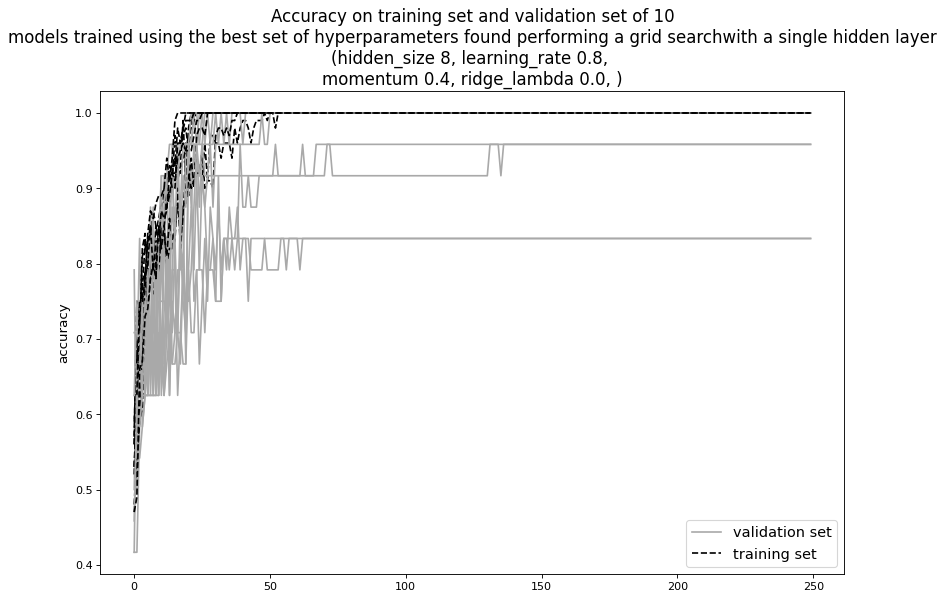

In [25]:
# plot the accuracy for monk1
plot_accuracy(histories, n_models, best_comb, local_path_plot_acc[0])

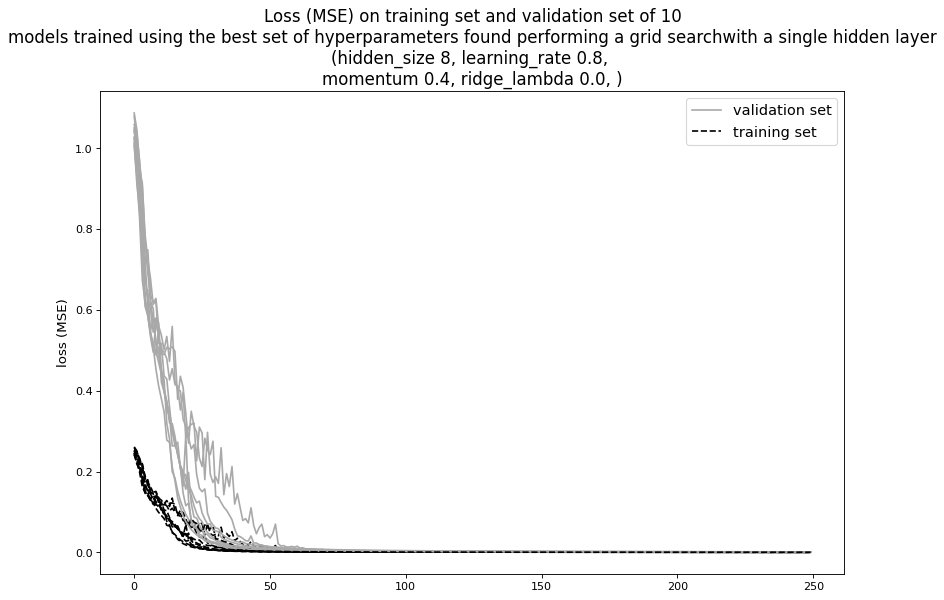

In [26]:
# plot the loss for monk1
plot_loss(histories, n_models, best_comb, local_path_plot_loss[0])

At this point we can select a model among those that wa have created and assess its generalization capabilities using the test set

In [27]:
# select the model
criterion = "best"
metric = "val_accuracy"
final_model_monk1 = select_model(models, histories, metric, criterion)

# create a dataloader for the test set
dataloader_test = define_test_dataloader(test_set_monk1)

# assess its generalization capabilities
final_accuracy = model_assessment(final_model_monk1, dataloader_test)
print("final accuracy on the test set:", final_accuracy.item())

# save the final model
save_model(final_model_monk1, local_path_final_model[0])

final score in the validation set: 1.0
final accuracy on the test set: 1.0


## Monk2 ##

now it's the turn of monk2

In [28]:
# execute the grid search
max_score, best_comb = grid_search(
    design_set_monk2, input_size, output_size, hyper_param_monk2, n_trials, num_epochs,
    n_kfolds, verbose=1, total_process=4
)

score: 1.0, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 1.0, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 1.0, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.9) (ridge_lambda = 0.0) 
score: 1.0, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.9841269801060359, hyperparameters: (hidden_size = 5) (learning_rate = 0.8) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.9801587263743083, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.9) (ridge_lambda = 0.0) 
score: 0.982142855723699, hyperparameters: (hidden_size = 5) (learning_rate = 0.8) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.9880952388048172, hyperparameters: (hidden_size = 5) (learning_rate = 0.5) (momentum = 0.8) (ridge_lambda = 0.0) 
score: 0.9722222189108531, hyperparameters: (hidden_size = 5) (learning_rate 

At this point we built 10 different models using the best configuration of hyperparameters

In [29]:
# create the dataloaders
dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl = define_dataloaders(design_set_monk2, 0.2)

# build the models with the best hyperparamters
n_models = 10

histories = [None]*n_models
models = [None]*n_models
for i in range(n_models):
    print("creating model n.", i)
    histories[i], models[i] = build_final_model(
        dataloader_tr, dataloader_vl, input_size, output_size, best_comb, 
        total_samples_tr, total_samples_vl, num_epochs, verbose=1
    )

creating model n. 0
final accuracy on the validation set  1.0
creating model n. 1
final accuracy on the validation set  1.0
creating model n. 2
final accuracy on the validation set  1.0
creating model n. 3
final accuracy on the validation set  1.0
creating model n. 4
final accuracy on the validation set  1.0
creating model n. 5
final accuracy on the validation set  1.0
creating model n. 6
final accuracy on the validation set  1.0
creating model n. 7
final accuracy on the validation set  1.0
creating model n. 8
final accuracy on the validation set  1.0
creating model n. 9
final accuracy on the validation set  1.0


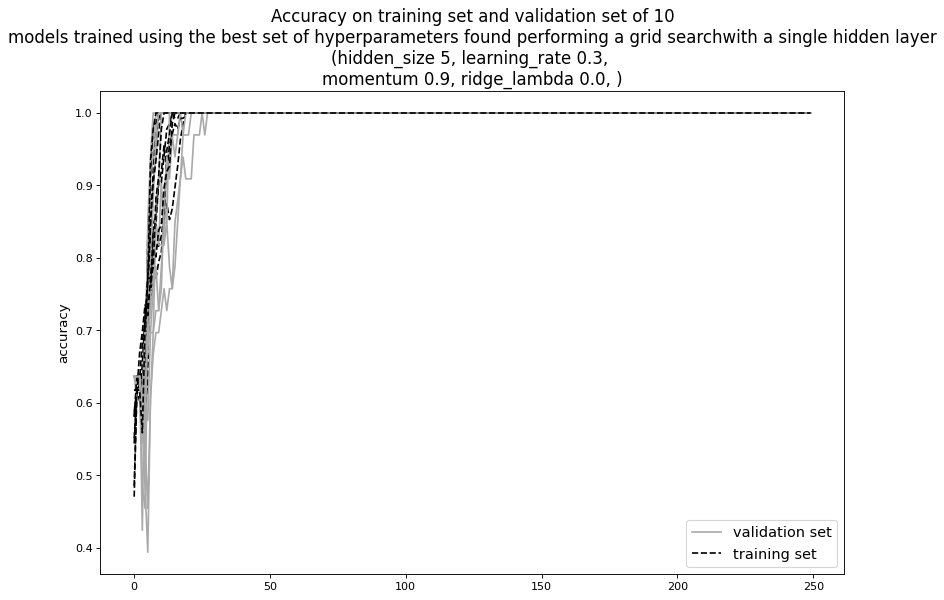

In [30]:
# plot the accuracy for monk2
plot_accuracy(histories, n_models, best_comb, local_path_plot_acc[1])

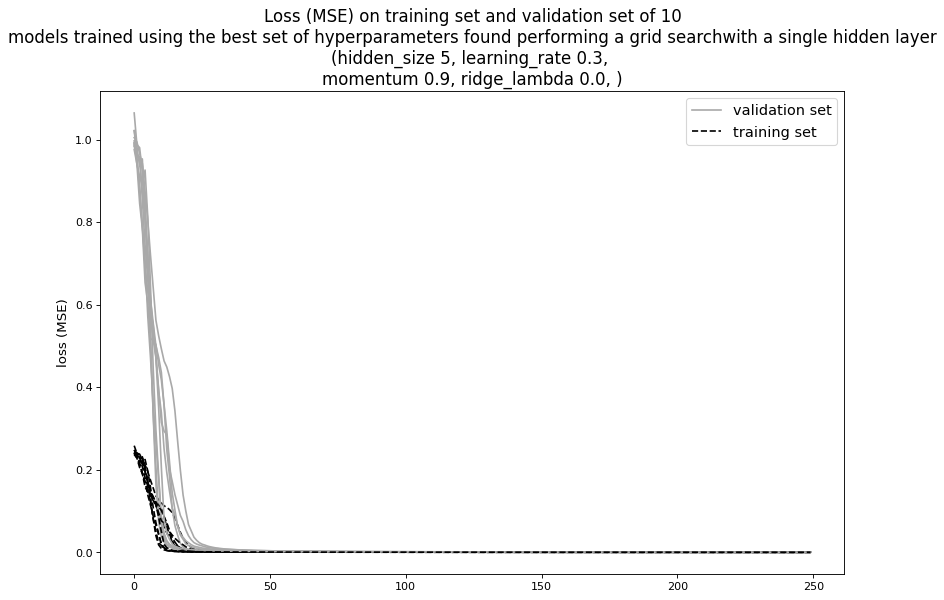

In [31]:
# plot the loss for monk2
plot_loss(histories, n_models, best_comb, local_path_plot_loss[1])

At this point we can select a model among those that wa have created and assess its generalization capabilities using the test set

In [32]:
# select the model
criterion = "best"
metric = "val_accuracy"
final_model_monk2 = select_model(models, histories, metric, criterion)

# create a dataloader for the test set
dataloader_test = define_test_dataloader(test_set_monk2)

# assess its generalization capabilities
final_accuracy = model_assessment(final_model_monk2, dataloader_test)
print("final accuracy on the test set:", final_accuracy.item())

# save the final model
save_model(final_model_monk2, local_path_final_model[1])

final score in the validation set: 1.0
final accuracy on the test set: 1.0


## Monk3 ##

Finally, we have to deal with monk3

In [33]:
# execute the grid search
max_score, best_comb = grid_search(
    design_set_monk3, input_size, output_size, hyper_param_monk3, n_trials, num_epochs,
    n_kfolds, verbose=1, total_process=4
)

score: 0.9344086050987244, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.4) (ridge_lambda = 0.01) 
score: 0.8831541140874227, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.6) (ridge_lambda = 0.0) 
score: 0.8963261644045513, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.4) (ridge_lambda = 0.0) 
score: 0.893817201256752, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.4) (ridge_lambda = 0.001) 
score: 0.8777777701616286, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.9) (ridge_lambda = 0.0) 
score: 0.9344086050987244, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.6) (ridge_lambda = 0.01) 
score: 0.8911290268103281, hyperparameters: (hidden_size = 5) (learning_rate = 0.1) (momentum = 0.9) (ridge_lambda = 0.001) 
score: 0.9290322562058767, hyperparameters: (hidden_size = 5) (learning_rate = 0.3) (momentum = 0.4) (ridge_lambda = 0.01) 
score: 0.9

At this point we built 10 different models using the best configuration of hyperparameters

In [34]:
# create the dataloaders
dataloader_tr, dataloader_vl, total_samples_tr, total_samples_vl = define_dataloaders(design_set_monk3, 0.2)

# build the models with the best hyperparamters
n_models = 10

histories = [None]*n_models
models = [None]*n_models
for i in range(n_models):
    print("creating model n.", i)
    histories[i], models[i] = build_final_model(
        dataloader_tr, dataloader_vl, input_size, output_size, best_comb, 
        total_samples_tr, total_samples_vl, num_epochs, verbose=1
    )

creating model n. 0
final accuracy on the validation set  0.9166666865348816
creating model n. 1
final accuracy on the validation set  0.9166666865348816
creating model n. 2
final accuracy on the validation set  0.9166666865348816
creating model n. 3
final accuracy on the validation set  0.9166666865348816
creating model n. 4
final accuracy on the validation set  0.9166666865348816
creating model n. 5
final accuracy on the validation set  0.9166666865348816
creating model n. 6
final accuracy on the validation set  0.9166666865348816
creating model n. 7
final accuracy on the validation set  0.9166666865348816
creating model n. 8
final accuracy on the validation set  0.9166666865348816
creating model n. 9
final accuracy on the validation set  0.9166666865348816


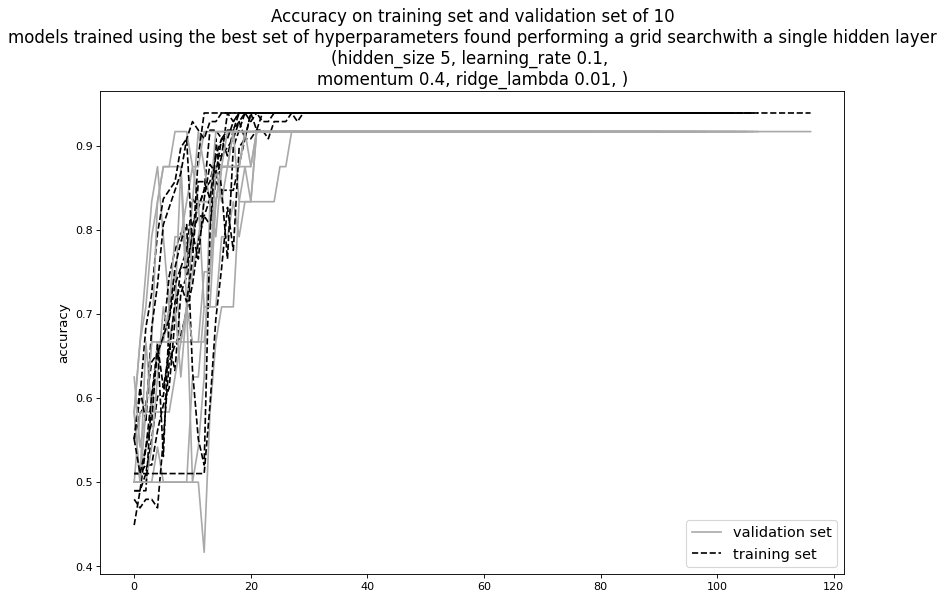

In [35]:
# plot the accuracy for monk3
plot_accuracy(histories, n_models, best_comb, local_path_plot_acc[2])

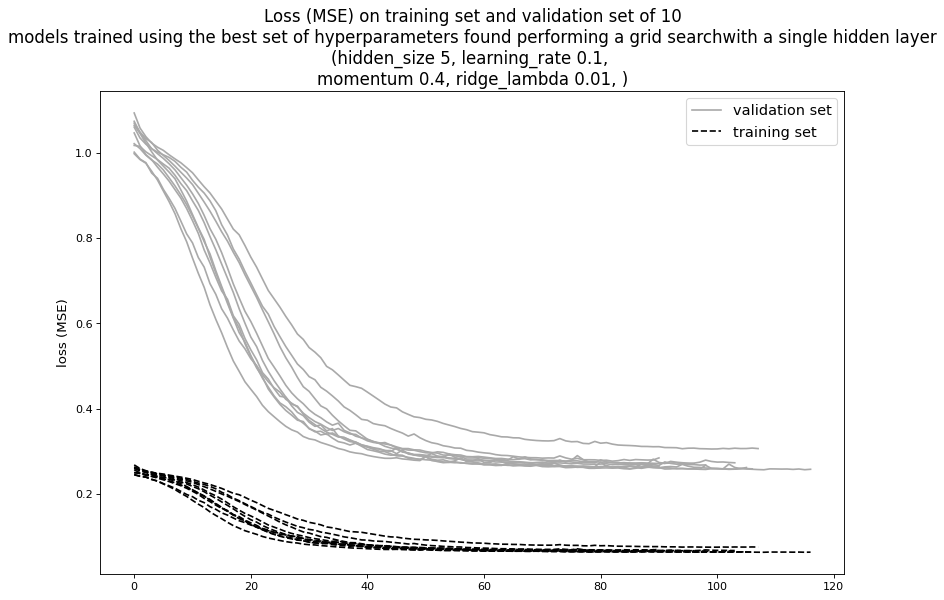

In [36]:
# plot the loss for monk3
plot_loss(histories, n_models, best_comb, local_path_plot_loss[2])

At this point we can select a model among those that wa have created and assess its generalization capabilities using the test set

In [42]:
# select the model
criterion = "average"
metric = "val_accuracy"
final_model_monk3 = select_model(models, histories, metric, criterion)

# create a dataloader for the test set
dataloader_test = define_test_dataloader(test_set_monk3)

# assess its generalization capabilities
final_accuracy = model_assessment(final_model_monk3, dataloader_test)
print("final accuracy on the test set:", final_accuracy.item())

# save the final model
save_model(final_model_monk3, local_path_final_model[2])

final score in the validation set: 0.9166666865348816
final accuracy on the test set: 0.9722222089767456
